In [1]:
# 레이블링이 완료된 데이터셋의 양이 적을 경우, 오토인코더를 활용해 사전훈련이 가능함

In [2]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version은 코랩에서만 동작합니다.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# 텐서플로 ≥2.0 필수
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("감지된 GPU가 없습니다. GPU가 없으면 LSTM과 CNN이 매우 느릴 수 있습니다.")
    if IS_COLAB:
        print("런타임 > 런타임 유형 변경 메뉴를 선택하고 하드웨어 가속기로 GPU를 고르세요.")

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)
tf.random.set_seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "autoencoders"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

감지된 GPU가 없습니다. GPU가 없으면 LSTM과 CNN이 매우 느릴 수 있습니다.
런타임 > 런타임 유형 변경 메뉴를 선택하고 하드웨어 가속기로 GPU를 고르세요.


In [5]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [7]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

4431872/4422102 [==============================] - 0s 0us/step


In [12]:
def show_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

## 1. 가중치 묶기

#### 인코더와 디코더를 따로 구성하여 오토인코더 학습

In [8]:
class DenseTranspose(keras.layers.Layer):
    def __init__(self, dense, activation=None, **kwargs):
        self.dense = dense
        self.activation = keras.activations.get(activation)
        super().__init__(**kwargs)
    def build(self, batch_input_shape):
        self.biases = self.add_weight(name="bias",
                                      shape=[self.dense.input_shape[-1]],
                                      initializer="zeros")
        super().build(batch_input_shape)
    def call(self, inputs):
        z = tf.matmul(inputs, self.dense.weights[0], transpose_b=True)
        return self.activation(z + self.biases)

In [34]:
dense_1 = keras.layers.Dense(100, activation="selu")
dense_2 = keras.layers.Dense(30, activation="selu")

tied_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    dense_1,
    dense_2
])

tied_decoder = keras.models.Sequential([
    DenseTranspose(dense_2, activation="selu"),
    DenseTranspose(dense_1, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

tied_ae = keras.models.Sequential([tied_encoder, tied_decoder])

tied_ae.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.SGD(learning_rate=1.5), metrics=[rounded_accuracy])
history = tied_ae.fit(X_train, X_train, epochs=10,
                      validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3265 - rounded_accuracy: 0.8966 - val_loss: 0.3051 - val_rounded_accuracy: 0.9131
Epoch 2/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2968 - rounded_accuracy: 0.9232 - val_loss: 0.2935 - val_rounded_accuracy: 0.9286
Epoch 3/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2912 - rounded_accuracy: 0.9285 - val_loss: 0.2966 - val_rounded_accuracy: 0.9167
Epoch 4/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2883 - rounded_accuracy: 0.9311 - val_loss: 0.2877 - val_rounded_accuracy: 0.9332
Epoch 5/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2864 - rounded_accuracy: 0.9329 - val_loss: 0.2870 - val_rounded_accuracy: 0.9325
Epoch 6/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2850 - rounded_accuracy: 0.9342 - val_loss: 0.2859 - val_rounded_accuracy: 0.9353
Epoch 7/10
1719/1719 [==================

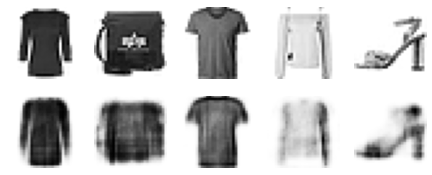

In [35]:
show_reconstructions(tied_ae)
plt.show()

#### 학습된 오토인코더의 인코더 부분을 재활용하여 지도 학습

In [36]:
np.unique(y_train)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [45]:
model = keras.models.Sequential([tied_encoder,
                                    keras.layers.Dense(10, activation="softmax")])

In [50]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
history = model.fit(X_test, y_test, epochs=20)
score = model.evaluate(X_valid, y_valid)
X_new = X_test[:10]
y_pred = model.predict(X_new)

Epoch 1/20
313/313 [==============================] - 3s 4ms/step - loss: 0.2365 - accuracy: 0.9145
Epoch 2/20
313/313 [==============================] - 2s 5ms/step - loss: 0.2280 - accuracy: 0.9154
Epoch 3/20
313/313 [==============================] - 2s 6ms/step - loss: 0.2113 - accuracy: 0.9211
Epoch 4/20
313/313 [==============================] - 1s 5ms/step - loss: 0.1999 - accuracy: 0.9265
Epoch 5/20
313/313 [==============================] - 2s 5ms/step - loss: 0.1915 - accuracy: 0.9310
Epoch 6/20
313/313 [==============================] - 1s 4ms/step - loss: 0.1804 - accuracy: 0.9341
Epoch 7/20
313/313 [==============================] - 1s 3ms/step - loss: 0.1712 - accuracy: 0.9377
Epoch 8/20
313/313 [==============================] - 1s 3ms/step - loss: 0.1613 - accuracy: 0.9422
Epoch 9/20
313/313 [==============================] - 1s 3ms/step - loss: 0.1559 - accuracy: 0.9442
Epoch 10/20
313/313 [==============================] - 1s 3ms/step - loss: 0.1467 - accuracy: 0.9481

In [51]:
prediction = model.predict(X_test)
pred = []
for i in range(len(prediction)):
  pred.append(np.argmax(prediction[i]))

In [52]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1000
           1       1.00      1.00      1.00      1000
           2       0.97      0.90      0.94      1000
           3       0.99      0.99      0.99      1000
           4       0.90      0.97      0.93      1000
           5       1.00      1.00      1.00      1000
           6       0.95      0.94      0.95      1000
           7       1.00      1.00      1.00      1000
           8       1.00      1.00      1.00      1000
           9       1.00      1.00      1.00      1000

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



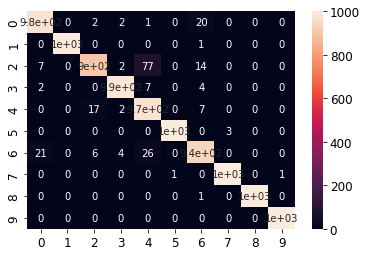

In [53]:
sns.heatmap(confusion_matrix(y_test,pred), annot = True)

## 2. 한 번에 오토인코더로 한 개씩 훈련하기

In [54]:
def train_autoencoder(n_neurons, X_train, X_valid, loss, optimizer,
                      n_epochs=10, output_activation=None, metrics=None):
    n_inputs = X_train.shape[-1]
    encoder = keras.models.Sequential([
        keras.layers.Dense(n_neurons, activation="selu", input_shape=[n_inputs])
    ])
    decoder = keras.models.Sequential([
        keras.layers.Dense(n_inputs, activation=output_activation),
    ])
    autoencoder = keras.models.Sequential([encoder, decoder])
    autoencoder.compile(optimizer, loss, metrics=metrics)
    autoencoder.fit(X_train, X_train, epochs=n_epochs,
                    validation_data=(X_valid, X_valid))
    return encoder, decoder, encoder(X_train), encoder(X_valid)

In [56]:
K = keras.backend
X_train_flat = K.batch_flatten(X_train) # equivalent to .reshape(-1, 28 * 28)
X_valid_flat = K.batch_flatten(X_valid)
enc1, dec1, X_train_enc1, X_valid_enc1 = train_autoencoder(
    100, X_train_flat, X_valid_flat, "binary_crossentropy",
    keras.optimizers.SGD(learning_rate=1.5), output_activation="sigmoid",
    metrics=[rounded_accuracy])
enc2, dec2, _, _ = train_autoencoder(
    30, X_train_enc1, X_valid_enc1, "mse", keras.optimizers.SGD(learning_rate=0.05),
    output_activation="selu")

Epoch 1/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.3440 - rounded_accuracy: 0.8880 - val_loss: 0.3111 - val_rounded_accuracy: 0.9161
Epoch 2/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3027 - rounded_accuracy: 0.9216 - val_loss: 0.2994 - val_rounded_accuracy: 0.9257
Epoch 3/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.2940 - rounded_accuracy: 0.9296 - val_loss: 0.2926 - val_rounded_accuracy: 0.9321
Epoch 4/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2885 - rounded_accuracy: 0.9348 - val_loss: 0.2882 - val_rounded_accuracy: 0.9369
Epoch 5/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2847 - rounded_accuracy: 0.9384 - val_loss: 0.2851 - val_rounded_accuracy: 0.9398
Epoch 6/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2821 - rounded_accuracy: 0.9410 - val_loss: 0.2828 - val_rounded_accuracy: 0.9416
Epoch 7/10
1719/1719 [=================

In [57]:
stacked_ae_1_by_1 = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    enc1, enc2, dec2, dec1,
    keras.layers.Reshape([28, 28])
])

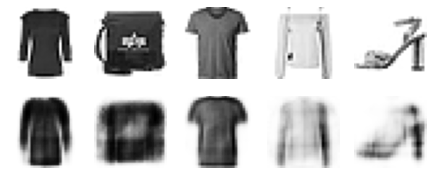

In [58]:
show_reconstructions(stacked_ae_1_by_1)
plt.show()

In [59]:
stacked_ae_1_by_1.compile(loss="binary_crossentropy",
                          optimizer=keras.optimizers.SGD(learning_rate=0.1), metrics=[rounded_accuracy])
history = stacked_ae_1_by_1.fit(X_train, X_train, epochs=10,
                                validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 17s 9ms/step - loss: 0.2869 - rounded_accuracy: 0.9340 - val_loss: 0.2885 - val_rounded_accuracy: 0.9341
Epoch 2/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2865 - rounded_accuracy: 0.9345 - val_loss: 0.2882 - val_rounded_accuracy: 0.9345
Epoch 3/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2862 - rounded_accuracy: 0.9348 - val_loss: 0.2879 - val_rounded_accuracy: 0.9345
Epoch 4/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2860 - rounded_accuracy: 0.9350 - val_loss: 0.2877 - val_rounded_accuracy: 0.9352
Epoch 5/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2858 - rounded_accuracy: 0.9353 - val_loss: 0.2875 - val_rounded_accuracy: 0.9354
Epoch 6/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2856 - rounded_accuracy: 0.9355 - val_loss: 0.2873 - val_rounded_accuracy: 0.9352
Epoch 7/10
1719/1719 [=================

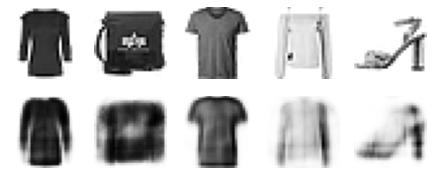

In [61]:
show_reconstructions(stacked_ae_1_by_1)
plt.show()